In [1]:
import numpy as np
import pandas as pd

from sb3_contrib import QRDQN
from stable_baselines3.common.monitor import Monitor

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials, evaluate_rollout
from scenarios.price_scenario import PriceScenarioGenerator

In [2]:
# === Load training data: full November 2024 ===
df_train, price_train, timestamps_train = load_price_data(
    csv_path="../data/raw/dayahead_2024_11.csv",
    resolution="15min",
)

# === Load evaluation data: first week of November 2025 ===
df_eval, price_eval, timestamps_eval = load_price_data(
    csv_path="../data/raw/dayahead_2025_11.csv",
    resolution="15min",
    time_range=("2025-11-01", "2025-11-07"),
)

print(len(price_eval), "time steps in a week (should be 672)")
print("Week from", timestamps_eval[0], "to", timestamps_eval[-1])

672 time steps in a week (should be 672)
Week from 2025-11-01 00:00:00+01:00 to 2025-11-07 23:45:00+01:00


In [3]:
# --------------------------------------------------
# Price forecast uncertainty scenarios (deterministic)
# --------------------------------------------------
forecast_horizon_hours=3.0 # 3h
dt_hours=0.25 # 15 min
forecast_horizon_steps = int(round(forecast_horizon_hours / dt_hours))  # 3h forecast, 15 min steps → 12 steps

price_scenario_gen = PriceScenarioGenerator(
    horizon_steps=forecast_horizon_steps,
    sigma0=0.01,   # small uncertainty for near future
    sigmaH=0.06,   # larger uncertainty for further future
    schedule="sqrt",   # realistic growth
    base_seed=1234,    # IMPORTANT: same seed = same scenarios
)

# ------------------------------------------------
# Training environment: uses full November 2024 as pool,
# each episode ~ one week starting at a random index.
# ------------------------------------------------
train_env_raw = BatteryEnv(
    price_series=price_train,
    demand_series=None,
    timestamps=timestamps_train,
    dt_hours=dt_hours,       
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,   # required for QR-DQN
    use_price_forecast=True,
    forecast_horizon_hours=forecast_horizon_hours,
    episode_days=7.0,            # one-week logical episode
    random_start=True,  
    random_seed=42,
    scenario_gen=price_scenario_gen,
    scenario_id=0,   # fixed scenario for fair comparison
)

# Wrap with Monitor for QR-DQN (logs episode stats)
train_env = Monitor(train_env_raw)

policy_kwargs = dict(n_quantiles=100)
qrdqn_model = QRDQN(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-3,
    buffer_size=50_000,
    learning_starts=1_000,
    batch_size=64,
    gamma=0.99,
    tau=1.0,
    train_freq=4,
    target_update_interval=1_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    exploration_fraction=0.3,
    verbose=1,
)

qrdqn_model.learn(
    total_timesteps=60_000,
    log_interval=10,
    progress_bar=True,
)

print("QR-DQN training completed.")
print(train_env.observation_space.shape)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 59,965/60,000  [ 0:03:47 < 0:00:01 , 263 it/s ]

QR-DQN training completed.
(21,)


Episode finished early at step 671
=== Financial Summary ===
Total revenue    (EUR): 8.360
Degradation cost (EUR): 0.367
Penalty cost     (EUR): 0.000
Total reward     (EUR): 7.993


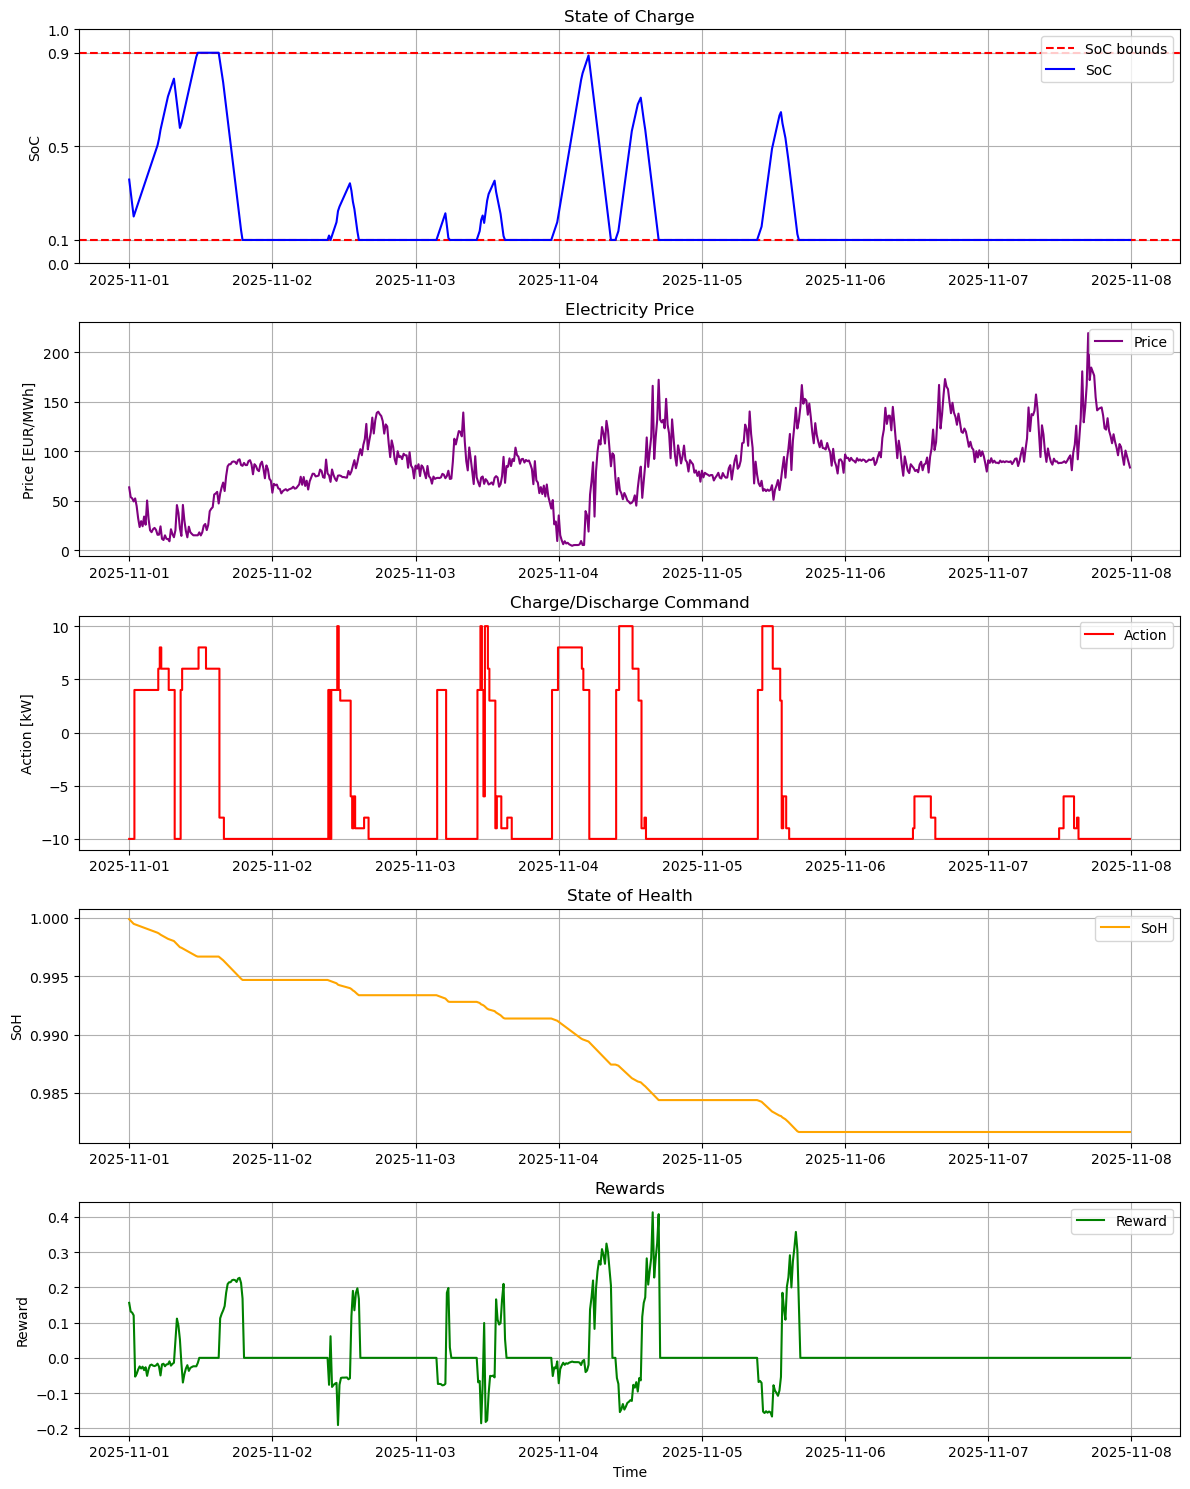

In [4]:
# Use a "fresh" env for evaluation (same config, different seed)
eval_env = BatteryEnv(
    price_series=price_eval,
    demand_series=None,
    timestamps=timestamps_eval,
    dt_hours=dt_hours,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=True,
    use_price_forecast=True,
    forecast_horizon_hours=forecast_horizon_hours,
    episode_days=7.0,             # matches the eval week length
    random_start=False, 
    random_seed=123, 
    scenario_gen=price_scenario_gen,
    scenario_id=0,        # SAME scenario
)

results = evaluate_rollout(
    model=qrdqn_model,
    env=eval_env,
)

evaluate_financials(
    revenue_list=results["revenue"],
    deg_cost_list=results["deg_cost"],
    penalty_list=results["penalty"],
)

plot_bess_rollout(
    soc_list=results["soc"],
    soh_list=results["soh"],
    reward_list=results["reward"],
    price_list=results["price_true"],
    action_list=results["action"],
    timestamps=timestamps_eval,
)